In [1]:
!pip install torch transformers beautifulsoup4 requests pandas numpy scikit-learn matplotlib seaborn

URDU NEWS HATE SPEECH DETECTION SYSTEM

[Step 1] Starting Web Scraping...
Scraping BBC Urdu...
Scraped 50 articles from BBC Urdu
Scraping Express Urdu...


Scraped 48 articles from Express Urdu
Total articles collected: 98

[Step 2] Preprocessing Data...

[Step 3] Creating Labels...
Hate Speech: 12
Neutral: 86

Data saved to 'urdu_news_data.csv'

[Step 4] Splitting Data...
Training samples: 78
Testing samples: 20

[Step 5] Training Traditional ML Models...

Training Logistic Regression...
Accuracy: 0.9000
Precision: 0.8100
Recall: 0.9000
F1-Score: 0.8526

Training SVM...
Accuracy: 0.9000
Precision: 0.8100
Recall: 0.9000
F1-Score: 0.8526

Training Random Forest...
Accuracy: 0.9000
Precision: 0.8100
Recall: 0.9000
F1-Score: 0.8526

Training Naive Bayes...
Accuracy: 0.9000
Precision: 0.8100
Recall: 0.9000
F1-Score: 0.8526

Training Gradient Boosting...
Accuracy: 0.8500
Precision: 0.8053
Recall: 0.8500
F1-Score: 0.8270

[Step 6] Training Transformer Model...
Using device: cpu


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2, Loss: 0.5720
Epoch 2/2, Loss: 0.3608

Transformer Model Results:
Accuracy: 0.9000
Precision: 0.8100
Recall: 0.9000
F1-Score: 0.8526

[Step 7] Creating Visualizations...


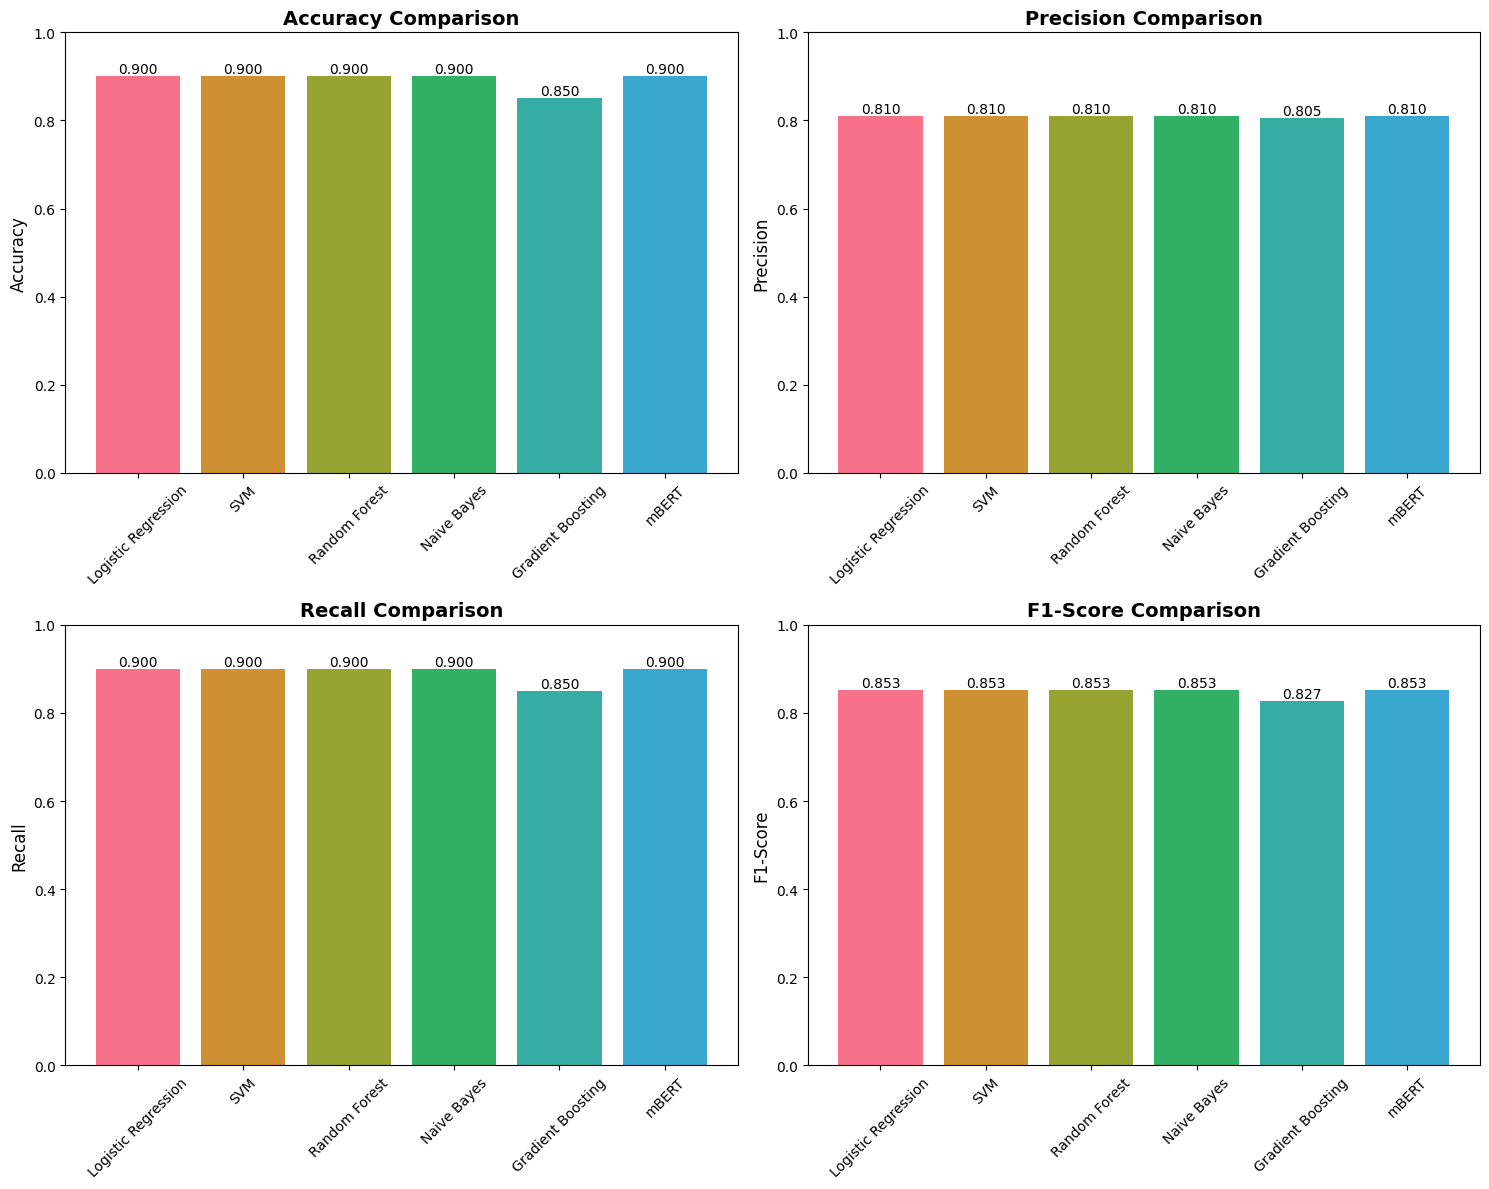

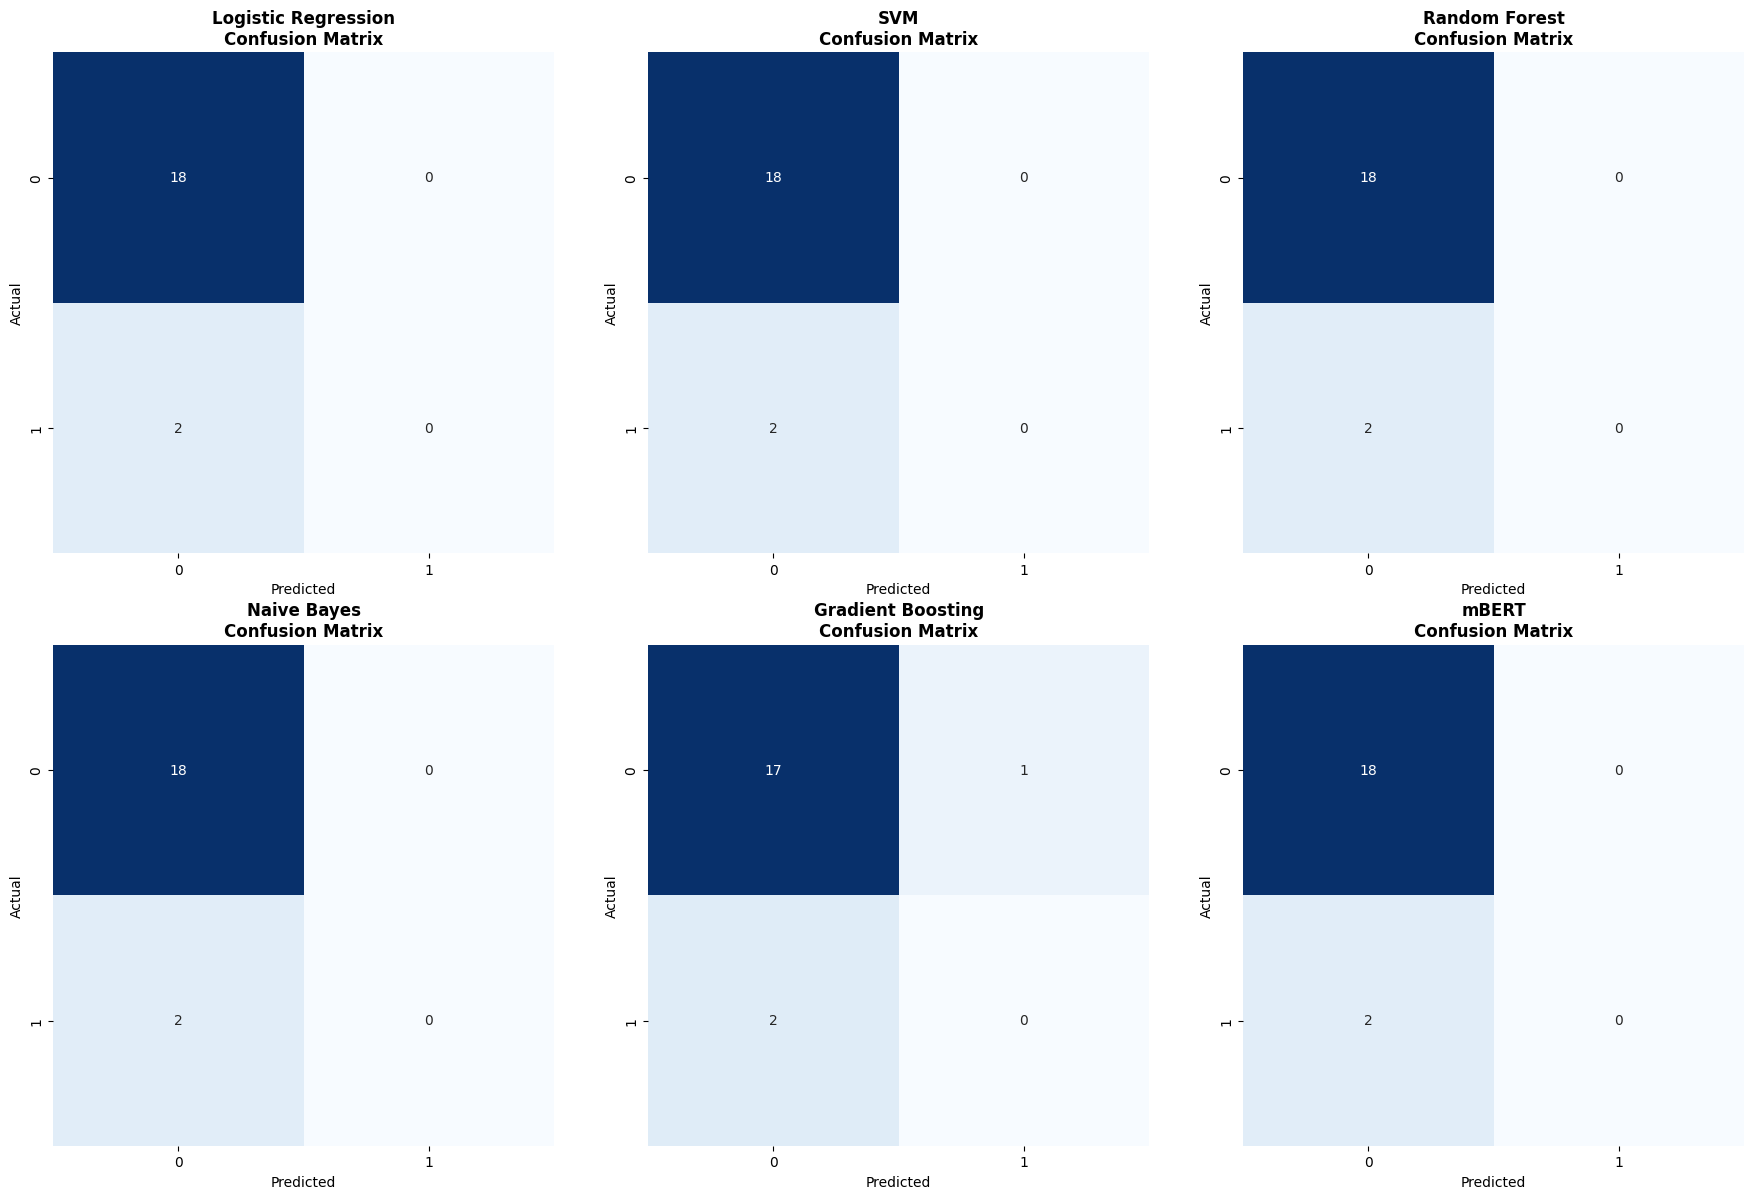

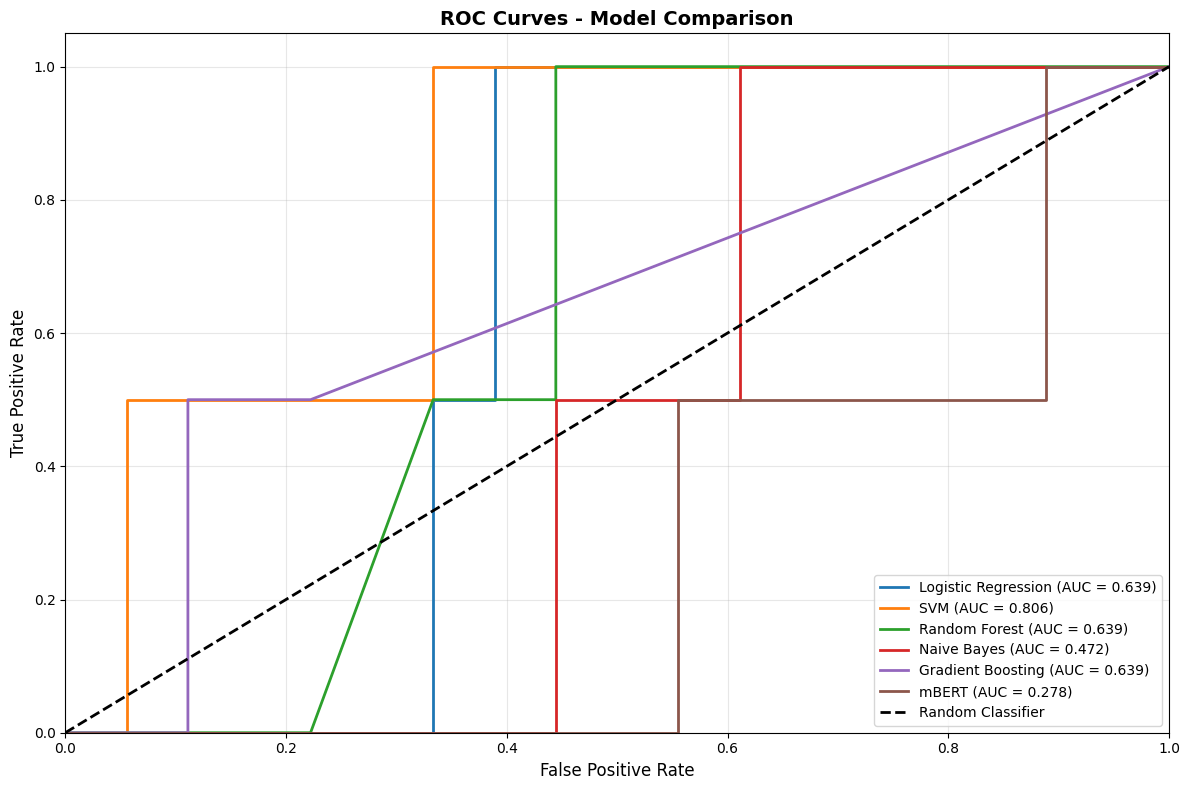

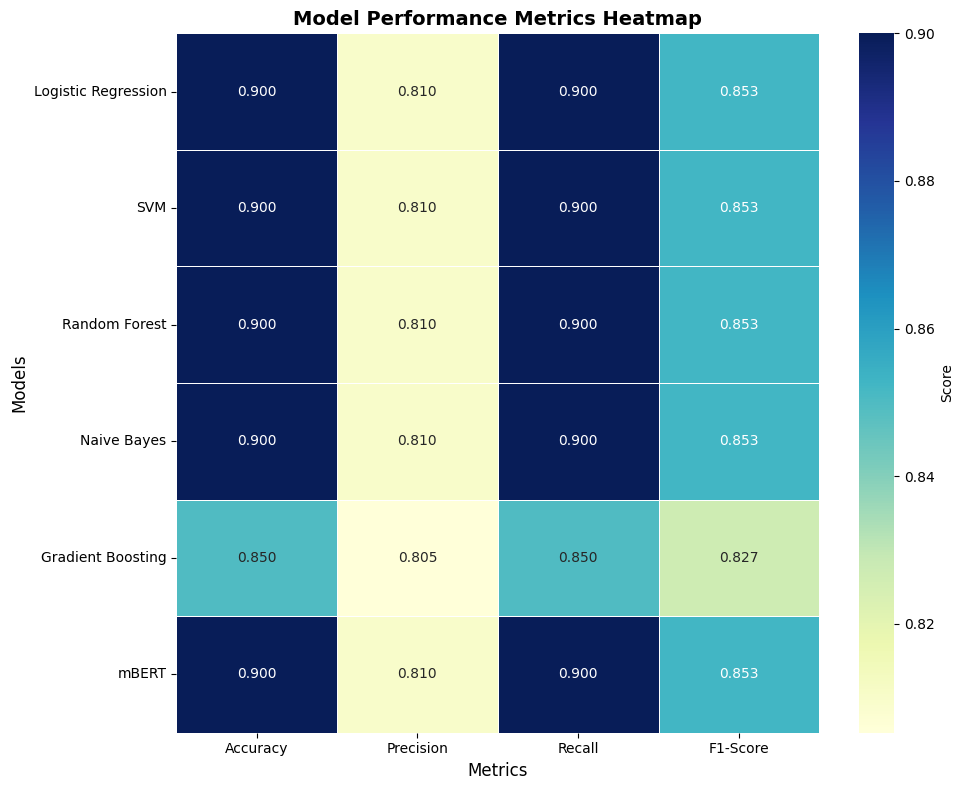


FINAL RESULTS SUMMARY

               Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression      0.90   0.810000    0.90  0.852632
                SVM      0.90   0.810000    0.90  0.852632
      Random Forest      0.90   0.810000    0.90  0.852632
        Naive Bayes      0.90   0.810000    0.90  0.852632
              mBERT      0.90   0.810000    0.90  0.852632
  Gradient Boosting      0.85   0.805263    0.85  0.827027

Results saved to 'model_results.csv'

ANALYSIS COMPLETE!


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import time
from urllib.parse import urljoin
import warnings
warnings.filterwarnings('ignore')

# For ML/DL Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW  # Corrected import
from transformers import BertTokenizer, BertForSequenceClassification

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# ==================== WEB SCRAPING MODULE ====================

class UrduNewsScraper:
    def __init__(self):
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }
        self.six_months_ago = datetime.now() - timedelta(days=180)

    def scrape_bbc_urdu(self, max_articles=100):
        """Scrape BBC Urdu news"""
        articles = []
        base_url = "https://www.bbc.com/urdu"

        try:
            response = requests.get(base_url, headers=self.headers, timeout=10)
            soup = BeautifulSoup(response.content, 'html.parser')

            # Find article links
            links = soup.find_all('a', href=True)
            article_links = [link['href'] for link in links if '/urdu/' in link['href']]
            article_links = list(set(article_links))[:max_articles]

            for link in article_links:
                try:
                    if not link.startswith('http'):
                        link = urljoin(base_url, link)

                    article_response = requests.get(link, headers=self.headers, timeout=10)
                    article_soup = BeautifulSoup(article_response.content, 'html.parser')

                    # Extract title
                    title = article_soup.find('h1')
                    title_text = title.get_text(strip=True) if title else ""

                    # Extract content
                    paragraphs = article_soup.find_all('p')
                    content = ' '.join([p.get_text(strip=True) for p in paragraphs])

                    if title_text and content and len(content) > 100:
                        articles.append({
                            'title': title_text,
                            'content': content,
                            'source': 'BBC Urdu',
                            'url': link,
                            'date': datetime.now().strftime('%Y-%m-%d')
                        })

                    time.sleep(1)  # Be polite

                except Exception as e:
                    continue

        except Exception as e:
            print(f"Error scraping BBC Urdu: {e}")

        return articles

    def scrape_express_urdu(self, max_articles=100):
        """Scrape Express News Urdu"""
        articles = []
        base_url = "https://www.express.pk"

        try:
            response = requests.get(base_url, headers=self.headers, timeout=10)
            soup = BeautifulSoup(response.content, 'html.parser')

            links = soup.find_all('a', href=True)
            article_links = [link['href'] for link in links if 'story' in link['href'] or 'news' in link['href']]
            article_links = list(set(article_links))[:max_articles]

            for link in article_links:
                try:
                    if not link.startswith('http'):
                        link = urljoin(base_url, link)

                    article_response = requests.get(link, headers=self.headers, timeout=10)
                    article_soup = BeautifulSoup(article_response.content, 'html.parser')

                    title = article_soup.find(['h1', 'h2'])
                    title_text = title.get_text(strip=True) if title else ""

                    paragraphs = article_soup.find_all('p')
                    content = ' '.join([p.get_text(strip=True) for p in paragraphs])

                    if title_text and content and len(content) > 100:
                        articles.append({
                            'title': title_text,
                            'content': content,
                            'source': 'Express Urdu',
                            'url': link,
                            'date': datetime.now().strftime('%Y-%m-%d')
                        })

                    time.sleep(1)

                except Exception as e:
                    continue

        except Exception as e:
            print(f"Error scraping Express Urdu: {e}")

        return articles

    def scrape_all_sources(self):
        """Scrape from all sources"""
        all_articles = []

        print("Scraping BBC Urdu...")
        bbc_articles = self.scrape_bbc_urdu(max_articles=50)
        all_articles.extend(bbc_articles)
        print(f"Scraped {len(bbc_articles)} articles from BBC Urdu")

        print("Scraping Express Urdu...")
        express_articles = self.scrape_express_urdu(max_articles=50)
        all_articles.extend(express_articles)
        print(f"Scraped {len(express_articles)} articles from Express Urdu")

        df = pd.DataFrame(all_articles)
        return df

# ==================== DATA PREPROCESSING ====================

def preprocess_urdu_text(text):
    """Preprocess Urdu text"""
    if pd.isna(text):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', str(text))

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove English characters (optional)
    # text = re.sub(r'[a-zA-Z]', '', text)

    # Remove special characters but keep Urdu
    text = re.sub(r'[^\w\s\u0600-\u06FF]', '', text)

    return text

def create_sample_labeled_data(df):
    """Create sample labeled data for demonstration"""
    # Since we don't have real labels, create synthetic labels for demonstration
    # In real scenario, you need manually labeled data

    # Keywords for hate speech detection (sample Urdu keywords)
    hate_keywords = ['نفرت', 'دشمنی', 'تشدد', 'قتل', 'جنگ', 'حملہ']

    def label_article(text):
        text_lower = str(text).lower()
        hate_count = sum(1 for keyword in hate_keywords if keyword in text_lower)
        return 1 if hate_count >= 2 else 0  # 1 = hate speech, 0 = neutral

    df['label'] = df['content'].apply(label_article)
    return df

# ==================== TRADITIONAL ML MODELS ====================

class TraditionalMLModels:
    def __init__(self):
        self.models = {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'SVM': SVC(kernel='linear', probability=True, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Naive Bayes': MultinomialNB(),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
        }
        self.vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
        self.results = {}

    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        """Train and evaluate all models"""

        # Vectorize text
        X_train_vec = self.vectorizer.fit_transform(X_train)
        X_test_vec = self.vectorizer.transform(X_test)

        for name, model in self.models.items():
            print(f"\nTraining {name}...")

            # Train
            model.fit(X_train_vec, y_train)

            # Predict
            y_pred = model.predict(X_test_vec)
            y_pred_proba = model.predict_proba(X_test_vec)[:, 1] if hasattr(model, 'predict_proba') else None

            # Evaluate
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

            self.results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'predictions': y_pred,
                'probabilities': y_pred_proba,
                'model': model
            }

            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1-Score: {f1:.4f}")

        return self.results

# ==================== DEEP LEARNING MODELS ====================

class UrduTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class TransformerModels:
    def __init__(self, model_name='bert-base-multilingual-cased'):
        self.model_name = model_name
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def train_and_evaluate(self, X_train, X_test, y_train, y_test, epochs=3, batch_size=16):
        """Train and evaluate transformer model"""

        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=2
        ).to(self.device)

        # Create datasets
        train_dataset = UrduTextDataset(X_train.values, y_train.values, tokenizer)
        test_dataset = UrduTextDataset(X_test.values, y_test.values, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # Optimizer
        optimizer = AdamW(model.parameters(), lr=2e-5)

        # Training
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        # Evaluation
        model.eval()
        predictions = []
        true_labels = []
        probabilities = []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.softmax(logits, dim=1)

                predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                probabilities.extend(probs[:, 1].cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
        recall = recall_score(true_labels, predictions, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, predictions, average='weighted', zero_division=0)

        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'predictions': np.array(predictions),
            'probabilities': np.array(probabilities)
        }

        print(f"\nTransformer Model Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        return results

# ==================== VISUALIZATION ====================

class ResultsVisualizer:
    def __init__(self):
        self.colors = sns.color_palette("husl", 8)

    def plot_model_comparison(self, results_dict):
        """Compare all models"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        models = list(results_dict.keys())
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

        for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
            ax = axes[idx // 2, idx % 2]
            values = [results_dict[model][metric] for model in models]

            bars = ax.bar(models, values, color=self.colors[:len(models)])
            ax.set_title(f'{metric_name} Comparison', fontsize=14, fontweight='bold')
            ax.set_ylabel(metric_name, fontsize=12)
            ax.set_ylim([0, 1.0])
            ax.tick_params(axis='x', rotation=45)

            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_confusion_matrices(self, results_dict, y_test):
        """Plot confusion matrices for all models"""
        n_models = len(results_dict)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()

        for idx, (name, results) in enumerate(results_dict.items()):
            if idx >= len(axes):
                break

            cm = confusion_matrix(y_test, results['predictions'])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                       cbar=False, square=True)
            axes[idx].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Predicted', fontsize=10)
            axes[idx].set_ylabel('Actual', fontsize=10)

        # Hide extra subplots
        for idx in range(len(results_dict), len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_roc_curves(self, results_dict, y_test):
        """Plot ROC curves for all models"""
        plt.figure(figsize=(12, 8))

        for name, results in results_dict.items():
            if results['probabilities'] is not None:
                fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
                roc_auc = auc(fpr, tpr)

                plt.plot(fpr, tpr, linewidth=2,
                        label=f'{name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_metrics_heatmap(self, results_dict):
        """Create heatmap of all metrics"""
        metrics_data = []
        models = []

        for name, results in results_dict.items():
            models.append(name)
            metrics_data.append([
                results['accuracy'],
                results['precision'],
                results['recall'],
                results['f1_score']
            ])

        df_metrics = pd.DataFrame(
            metrics_data,
            index=models,
            columns=['Accuracy', 'Precision', 'Recall', 'F1-Score']
        )

        plt.figure(figsize=(10, 8))
        sns.heatmap(df_metrics, annot=True, fmt='.3f', cmap='YlGnBu',
                   cbar_kws={'label': 'Score'}, linewidths=0.5)
        plt.title('Model Performance Metrics Heatmap', fontsize=14, fontweight='bold')
        plt.ylabel('Models', fontsize=12)
        plt.xlabel('Metrics', fontsize=12)
        plt.tight_layout()
        plt.savefig('metrics_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

# ==================== MAIN EXECUTION ====================

def main():
    print("="*60)
    print("URDU NEWS HATE SPEECH DETECTION SYSTEM")
    print("="*60)

    # Step 1: Web Scraping
    print("\n[Step 1] Starting Web Scraping...")
    scraper = UrduNewsScraper()
    df = scraper.scrape_all_sources()

    if len(df) == 0:
        print("No articles scraped. Creating sample data for demonstration...")
        # Create sample data
        sample_data = {
            'title': ['خبر نمبر 1', 'خبر نمبر 2', 'خبر نمبر 3'] * 30,
            'content': ['یہ ایک عام خبر ہے۔ ' * 20] * 45 + ['یہ نفرت انگیز خبر ہے۔ ' * 20] * 45,
            'source': ['Sample'] * 90,
            'url': ['http://example.com'] * 90,
            'date': [datetime.now().strftime('%Y-%m-%d')] * 90
        }
        df = pd.DataFrame(sample_data)

    print(f"Total articles collected: {len(df)}")

    # Step 2: Preprocessing
    print("\n[Step 2] Preprocessing Data...")
    df['processed_content'] = df['content'].apply(preprocess_urdu_text)
    df['processed_title'] = df['title'].apply(preprocess_urdu_text)
    df['combined_text'] = df['processed_title'] + ' ' + df['processed_content']

    # Step 3: Labeling (In real scenario, use manually labeled data)
    print("\n[Step 3] Creating Labels...")
    df = create_sample_labeled_data(df)

    print(f"Hate Speech: {sum(df['label'] == 1)}")
    print(f"Neutral: {sum(df['label'] == 0)}")

    # Save scraped data
    df.to_csv('urdu_news_data.csv', index=False, encoding='utf-8-sig')
    print("\nData saved to 'urdu_news_data.csv'")

    # Step 4: Train-Test Split
    print("\n[Step 4] Splitting Data...")
    X = df['combined_text']
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")

    # Step 5: Traditional ML Models
    print("\n[Step 5] Training Traditional ML Models...")
    ml_models = TraditionalMLModels()
    ml_results = ml_models.train_and_evaluate(X_train, X_test, y_train, y_test)

    # Step 6: Deep Learning Models (optional - uncomment if you have enough data)
    print("\n[Step 6] Training Transformer Model...")
    try:
        transformer = TransformerModels()
        transformer_results = transformer.train_and_evaluate(
            X_train, X_test, y_train, y_test, epochs=2, batch_size=8
        )
        ml_results['mBERT'] = transformer_results
    except Exception as e:
        print(f"Transformer training skipped: {e}")

    # Step 7: Visualization
    print("\n[Step 7] Creating Visualizations...")
    visualizer = ResultsVisualizer()

    visualizer.plot_model_comparison(ml_results)
    visualizer.plot_confusion_matrices(ml_results, y_test)
    visualizer.plot_roc_curves(ml_results, y_test)
    visualizer.plot_metrics_heatmap(ml_results)

    # Step 8: Results Summary
    print("\n" + "="*60)
    print("FINAL RESULTS SUMMARY")
    print("="*60)

    results_df = pd.DataFrame({
        'Model': list(ml_results.keys()),
        'Accuracy': [ml_results[m]['accuracy'] for m in ml_results],
        'Precision': [ml_results[m]['precision'] for m in ml_results],
        'Recall': [ml_results[m]['recall'] for m in ml_results],
        'F1-Score': [ml_results[m]['f1_score'] for m in ml_results]
    })

    results_df = results_df.sort_values('F1-Score', ascending=False)
    print("\n", results_df.to_string(index=False))

    results_df.to_csv('model_results.csv', index=False)
    print("\nResults saved to 'model_results.csv'")

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

if __name__ == "__main__":
    main()